# Using Spotify Data to Predict Music Review Scores, or "Just *How* Trash is my Music Taste?" (According to Pitchfork)

**by Siddha Mavuram**
<img src="https://www.vrfocus.com/wp-content/uploads/2017/07/pitchfork-logo2.png" width = 50% height = 50%/>

Table of Contents:

* [Introduction](#introduction)
* [Data Collection / Processing](#data)
* [EDA / Visualization](#eda)
* [Machine Learning](#ml)
* [Conclusion](#conclusion)


## Introduction <a id='introduction'></a>

Since its inception in 1995, the music review blog Pitchfork has become notorious in independent music circles. Their coverage has been known to elevate unknown and underground talent (their highest reviewed albums are  mostly [indie and more inaccesible music](https://pitchfork.com/best/high-scoring-albums/?page=5)), but it has also used its influence to demolish many bands entirely (see: disasterously infamous reviews of the bands [Jet](https://pitchfork.com/reviews/albums/9464-shine-on/) and [Black Kids](https://pitchfork.com/reviews/albums/11617-partie-traumatic/), whose careers have never recovered). Many of its most famous reviews have seemingly shifted the culture and conversation around musicians and influenced other outlets' opinions, like its unabashed praise of Kanye West's [My Beautiful Dark Twisted Fantasy](https://pitchfork.com/reviews/albums/14880-my-beautiful-dark-twisted-fantasy/). Although their influence has waned in recent years with the growing popularity of other review outlets like The Needle Drop or the website Rate Your Music, it still maintains its status as a crucial tastemaker among many circles for its consistently off-the-wall and obscure taste. 

The purpose of this project is to see if we can model the idiosyncratic tastes of the Pitchfork staff in a quantitative way. From [Kaggle](https://www.kaggle.com/nolanbconaway/pitchfork-data), I have found a dataset that has every single review score that the website has given out over the past 20+ years until 2017, categorized by genre and a number of other metrics. Using this, combined with specific Spotify audio track features for the songs on those albums, we are going to explore markers for what Pitchfork considers "good" music, and whether there is any specific music "signature" that Pitchfork's highest reviews tend to gravitate towards. 

Using this data, can we create a model to rate any given Spotify playlist or album, giving it its own Pitchfork score? Is your playlist "Best New Music"? Let's find out!

In [47]:
import sqlite3
import pandas 
import matplotlib.pyplot as plt
import numpy as np
import requests
#the next line imports a file containing api keys
from credentials import CLIENT_ID, CLIENT_SECRET
import json
import matplotlib.pyplot as plt
import pprint
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor

#base urls for Spotify API
AUTH_URL = 'https://accounts.spotify.com/api/token'
API_URL = 'https://api.spotify.com/v1/'
SEARCH_URL = 'https://api.spotify.com/v1/search'
TRACKS_URL = 'https://api.spotify.com/v1/tracks'
TRACK_URL = "https://api.spotify.com/v1/albums/" #"/{id}/tracks"
FEATURES_URL = "https://api.spotify.com/v1/audio-features/"

db = 'database.sqlite'
conn = sqlite3.connect(db)
display(conn)

# Data Collection / Processing <a id='data'></a>

First, we need to gather some data from the given database. The sqlite database is split up into several tables. The relevant ones we will use are years, genres, and reviews. Luckily, they all share the same primary key (reviewid) which will make joining the tables simple. 

Afterwards, we must do some cleanup of the data in order to make computations simpler. First, I rename the "year" column to "year_released" for clarity. Then, I convert that row's data type to ints instead of floats to compare it to other fields.   

In [48]:
# joining data from the years table (year of album release) and genres table

query = """SELECT * FROM reviews
            INNER JOIN years 
                ON reviews.reviewid == years.reviewid 
            INNER JOIN genres
                ON reviews.reviewid == genres.reviewid
            """
reviews = pandas.read_sql(query, conn)

reviews = reviews.rename(columns={"year": "year_released"})

#changing year_released column to ints instead of floats
reviews['year_released'] = reviews['year_released'].fillna(-1)
reviews['year_released'] = reviews['year_released'].astype(int)
reviews['year_released'] = reviews['year_released'].replace('-1', np.nan)

#removing duplicate columns
reviews = reviews.loc[:,~reviews.columns.duplicated()]

Pitchfork, and the music press in general, is sometimes controversially known for having periodic critical reevaluations of works that were originally not well recieved. One cannonical example of this is Weezer's *Pinkerton*, which was lambasted by the music press on its release in 1996, but whose musical influence was so great that, upon a deluxe rerelease in 2010, Pitchfork awarded it a [perfect 10/10 score](https://pitchfork.com/reviews/albums/14817-weezer-pinkerton-deluxe-edition-death-to-false-metal/)(\*). Another example of this is the reaction to Hip-Hop producer J-Dilla's final (non-posthumous) album *Donuts*. The album was well recieved, but not exceptionally so -- Pitchfork awarded it a 7.9; Rolling Stone gave it a 3.5/5. However, over time the influence of the album grew, and on its reissue, Pitchfork gave it a [10/10](https://pitchfork.com/reviews/albums/17510-donuts-45-box-set/).


Taking this into account, to better model the idiosyncrasies of Pitchfork, whose takes are often odd in their own iconic way, I have dropped all rows where the review date is over a year longer than after the release date. This allows only the "freshest" opinions to be considered.

Likewise, in order to minimize the number of API calls needed down the road, I have also dropped all the rows whose albums are not in the rock genre. Rock makes up the greatest percentage of Pitchfork reviews (See the pie chart below), and from a cursory glance at the head of the data, also comprises a wide variety of sounds between harder rock and more indie music. This will give the most diversity in sounds so that the song features data can be sufficiently developed.

(\*) More information about Weezer's critical reevaluation can be found [here](https://www.rollingstone.com/music/music-features/how-weezers-pinkerton-went-from-embarrassing-to-essential-105567/)

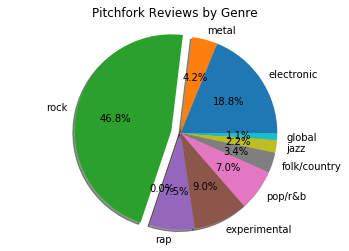

In [49]:
# Pie chart of number of Pitchfork reviews by genre
sizes = []
#print(labels)
labels = reviews.genre.unique()
#print(len(labels))
explode = (0, 0, 0.1, 0, 0, 0, 0, 0, 0, 0)  
for genre in reviews.genre.unique():
    #print(str(genre) + " reviews: " + str(len(reviews[(reviews.genre == genre)])))
    sizes.append(len(reviews[(reviews.genre == genre)]))
    
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, explode=explode)
plt.axis('equal')
plt.title("Pitchfork Reviews by Genre")
plt.show()


After joining data from several tables in the provided sqlite database, we have generated a dataframe with these columns:

In [50]:
#dropping non-rock
reviews = reviews[(reviews.genre == "rock")]
#dropping reviews of older work
reviews = reviews[reviews.pub_year - reviews.year_released <= 2]

reviews.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,year_released,genre
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,2016,rock
3,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017,2016,rock
23,22718,not the actual events ep,nine inch nails,http://pitchfork.com/reviews/albums/22718-not-...,6.3,0,benjamin scheim,contributor,2016-12-28,2,28,12,2016,2016,rock
26,22695,"early tapes, 1996-1998",the microphones,http://pitchfork.com/reviews/albums/22695-earl...,6.5,0,benjamin scheim,contributor,2016-12-27,1,27,12,2016,2016,rock
29,22532,turn into,jay som,http://pitchfork.com/reviews/albums/22532-turn...,8.2,0,quinn moreland,assistant editor,2016-12-23,4,23,12,2016,2016,rock


The next bit of code is some boilerplate needed to start using the Spotify API. CLIENT_ID and CLIENT_SECRET for this project are obtained through the Spotify Web API dashboard interface. They are located in a file called credentials.py in this directory. That file has not been uploaded for obvious reasons. Using CLIENT_ID and CLIENT_SECRET, we then send a POST request to the Spotify API which will return an access token. Using this, we can start querying the Web API.

In [51]:
#Some boilerplate needed to start querying the Spotify API
auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
})

access_token = auth_response.json()['access_token']
headers = {
    'Authorization': 'Bearer {token}'.format(token=access_token),
    'Accept': 'application/json',
    'Content-Type': 'application/json'
}

Now, we need to get some information about every album in the pared down list of reviews. Spotify has an API that will return some features like Dancability, Acousticness and Liveness about a track. However, to access the endpoint for those features, Spotify needs their own internal ID for that track. However, we only have a list of albums. This means that the flow of calls to the Spotify API will need to be:
1. query the search endpoint for each album's spotifyID (This will remove a chunk of albums that aren't on Spotify)
2. using each album's spotifyID, query the albums endpoint for the spotifyID of each song on it
3. for each song's spotify ID, query the audio features endpoint to return the audio features

To prevent the API calls taking a long time every time the notebook is run, I ran the calls once, wrote the results to disk, and read from those files in subsequent runs. The code to generate the API calls is also included.

In [52]:
# This code was used to generate the initial ids.
# This uses the Spotify web API search endpoint to get the spotify ID of an album
# They were then saved to a file so that further API calls would be unnecesary
# Subsequent runs of the program read from the file created, titled rock_ids.txt

"""
ids = []
for idx, rev in reviews.iterrows():
    query = "album:" + rev['title'] + " artist:" + rev['artist']
    #print(query)
    payload = {
        'q' : query,
        'type' : 'album'
    }
    #print(payload)
    g = requests.get(
        url = SEARCH_URL,
        headers = headers,
        params = payload
    )
    print(g.status_code)
    print(idx)
    r = json.loads(g.text)
    if (len(r['albums']['items']) != 0):
        ids.append(r['albums']['items'][0]['id'])
    else: 
        ids.append("0")
"""

# The following code was run to write the results of the API calls to disk
"""
f = open("rock_ids.txt", "w")

for id in ids:
    f.write('%s\n' % id)
"""

# reading ids from the text file
with open('rock_ids.txt', 'r') as f:
    ida = [line.strip() for line in f]

reviews["spotify_id"] = ida
reviews.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,year_released,genre,spotify_id
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,2016,rock,5M3Cx38HT8sD8ulnrSZsXi
3,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017,2016,rock,0
23,22718,not the actual events ep,nine inch nails,http://pitchfork.com/reviews/albums/22718-not-...,6.3,0,benjamin scheim,contributor,2016-12-28,2,28,12,2016,2016,rock,0
26,22695,"early tapes, 1996-1998",the microphones,http://pitchfork.com/reviews/albums/22695-earl...,6.5,0,benjamin scheim,contributor,2016-12-27,1,27,12,2016,2016,rock,4MidlO3UE5TXZ7NK0Nloc8
29,22532,turn into,jay som,http://pitchfork.com/reviews/albums/22532-turn...,8.2,0,quinn moreland,assistant editor,2016-12-23,4,23,12,2016,2016,rock,3hGEiHWq02qRrTIWqJrk7U


Some of the results of this initial pruning were dissapointing. For instance, in the head of the resulting spotify ID grab (see above), the *Not the Actual Events EP* from Nine Inch Nails does not seem to have a matching spotify id, despite the fact that I *know* I have actually listened to this album on Spotify before(\*). This discrepancy could stem from issues in accurate titling across the database paired with the fact that the API search was not a fuzzy search and included the entire text of the title and the artist. An area for possible improvement could be better entity resolution. However, with the scope (and time limit!) of this project, a deep dive into total accuracy might be overkill. Alas. Onward!

(\*) actual screenshot of my last.fm scrobbles (listens) of Nine Inch Nails songs. I have listened to 1 track off *Not the Actual Events EP* exactly once in 2018:
<img src="NIN_scrobbles.png" width = 50% height = 50%/>


In [53]:
#some extra cleanup
reviews = reviews[reviews["spotify_id"] != "0"]
reviews = reviews.reset_index()

Now we must use the API to get spotifyIDs for each song on each album.

We then create a new dataframe for each song of each album that was reviewed. With this, we can easily connect feature data later. Once again, to limit API calls, the API calling code was run and the results were written to disk and read from in subsequent runs of the program.

In [54]:
# the following code was run once to generate a csv file titled song_ids.csv.
# The file contains columns for song spotify id, review_id, and song_title
# the last line writes the dataframe to disk

# This code took ~1/2 hour to run!
"""songs = pandas.DataFrame(columns=['reviewid', 'song_title', 'spotify_id'])

for idx, review in reviews.iterrows():
    print(str(idx) + " " + review.title)
    payload = {
        'ids' : review.spotify_id
    }
    g = requests.get(
        url = TRACK_URL,
        headers = headers,
        params = payload
    )
    r = json.loads(g.text)
    for track in r['albums'][0]['tracks']['items']:
        #print(track['name'])
        new_row = {'reviewid':review.reviewid, 'song_title':track['name'], 'soptify_id': track['id']}
        songs = songs.append(new_row, ignore_index=True)
        
songs.to_csv("song_ids.csv")"""

#reading from / cleaning up the saved data
songs = pandas.read_csv('song_ids.csv', index_col=0)
songs = songs.drop(['spotify_id'], axis=1)
songs = songs.rename(columns={'soptify_id':'spotify_id'})
columnsTitles=["spotify_id","reviewid","song_title"]
songs=songs.reindex(columns=columnsTitles)
songs.head()

,spotify_id,reviewid,song_title
0,0ixa7hOenvqfHYe2Rh6ZIb,22659,Introduction
1,4yjlM9f8HSeUc9qWVTrKd2,22659,That Clown's Got A Gun
2,76r8GMCfAFttfKqvTKH623,22659,The Lottery
3,7ys9JxHIV3QlJXPDQ6vbkc,22659,God's Chest
4,7ib5NOykP6HOG6VdjeS6qz,22659,Who Made The Man?


This dataframe will give us the spotifyid for every song in every album of the original Pitchfork database.

Now, to get song feature data, we will query the Spotify API once more, this time at the audio features endpoint. Because doing ~90,000 calls to get features for all of these tracks would take too long, we are only going to do it with the first 10,000 tracks. Again, the API fetching code is run once, written to disk, and subsequently read from.

In [55]:
sample = songs.iloc[:10000]

#API Fetching code
"""
for idx, song in sample.iterrows():

    g = requests.get(
        url = FEATURES_URL + song.soptify_id,
        headers = headers,
    )
    print(str(idx))
    r = json.loads(g.text)
    song_features = song_features.append(r, ignore_index=True)

    
song_features.head()

song_features.to_csv("song_features.csv")"""

song_features = pandas.read_csv('song_features.csv', index_col=0)

# now some data cleanup and matching scores to the features
song_features = pandas.merge(song_features,
                             songs,
                             left_on = ['id'],
                             right_on = ['spotify_id'],
                             how = "left"
                            )
song_features = song_features.drop(['spotify_id'], axis=1)

song_features = pandas.merge(song_features,
                            reviews[['reviewid', 'score', 'best_new_music', "pub_year"]],
                            on = "reviewid",
                            how = "left")

song_features.head()

,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,...,time_signature,track_href,type,uri,valence,reviewid,song_title,score,best_new_music,pub_year
0,0.913000,https://api.spotify.com/v1/audio-analysis/0ixa...,0.613,139624.0,0.850,0ixa7hOenvqfHYe2Rh6ZIb,0.000012,7.0,0.3770,-9.002,...,3.0,https://api.spotify.com/v1/tracks/0ixa7hOenvqf...,audio_features,spotify:track:0ixa7hOenvqfHYe2Rh6ZIb,0.471,22659,Introduction,7.3,0,2017
1,0.000878,https://api.spotify.com/v1/audio-analysis/4yjl...,0.420,120778.0,0.782,4yjlM9f8HSeUc9qWVTrKd2,0.024500,6.0,0.3870,-6.051,...,4.0,https://api.spotify.com/v1/tracks/4yjlM9f8HSeU...,audio_features,spotify:track:4yjlM9f8HSeUc9qWVTrKd2,0.640,22659,That Clown's Got A Gun,7.3,0,2017
2,0.062500,https://api.spotify.com/v1/audio-analysis/76r8...,0.566,113039.0,0.791,76r8GMCfAFttfKqvTKH623,0.000001,2.0,0.0759,-5.641,...,4.0,https://api.spotify.com/v1/tracks/76r8GMCfAFtt...,audio_features,spotify:track:76r8GMCfAFttfKqvTKH623,0.742,22659,The Lottery,7.3,0,2017
3,0.005730,https://api.spotify.com/v1/audio-analysis/7ys9...,0.284,258311.0,0.887,7ys9JxHIV3QlJXPDQ6vbkc,0.093400,4.0,0.1190,-6.396,...,4.0,https://api.spotify.com/v1/tracks/7ys9JxHIV3Ql...,audio_features,spotify:track:7ys9JxHIV3QlJXPDQ6vbkc,0.533,22659,God's Chest,7.3,0,2017
4,0.000013,https://api.spotify.com/v1/audio-analysis/7ib5...,0.310,208445.0,0.856,7ib5NOykP6HOG6VdjeS6qz,0.331000,6.0,0.1910,-6.133,...,4.0,https://api.spotify.com/v1/tracks/7ib5NOykP6HO...,audio_features,spotify:track:7ib5NOykP6HOG6VdjeS6qz,0.646,22659,Who Made The Man?,7.3,0,2017


We now have a dataframe with the track feature data for every song in every album of the original Pitchfork database, alongside the merged in scores from the previous dataframe. 

The features that Spotify can give you about a track are, at a glance:
* acousticness - how acoustic/electric the track is
* danceability - how suitable the track is for dancing
* energy - how intense the track is
* instrumentalness - prediction of whether the track has no vocals
* key - the harmonic key of the track
* liveness - prediction of whether there is an live audience in the track
* loudness - how loud the track is
* speechiness - detects the presence of spoken words in a track
* valence - descibes the emotional positivity of a track
* tempo - estimated beats per minute of a track
* duration_ms - length of the track in milliseconds
* time signature - estimated beats per measure of the track

We will discuss the best_new_music column in depth later, although it is worth it to point out now that it comes from the original Pitchfork dataset.

## EDA / Visualization <a id='eda'></a>

Now that we have some statistics about the individual songs on each album of the original dataset, we can start to do some visualizations to search for correlations.

Here, I have grouped the songs by album, averaging each of the key metrics we want to visualize of each of the individual songs. I use an average instead of the mode or maximum to better represent the diversity of album structures. In my opinion ([and](https://www.popmatters.com/183929-the-18-stock-ways-of-beginning-and-ending-a-song-2495636646.html?rebelltitem=2#rebelltitem2) in [the](https://blog.landr.com/album-sequencing/) opinion [of](https://www.bbc.co.uk/music/articles/30e04f90-9015-4411-8c96-06c9bf8bc7e8) many [others](https://www.izotope.com/en/learn/album-sequencing-in-the-age-of-streaming.html)) album sequencing has a great impact on the emotional narrative of an album. Some of my favorite albums take the listener on a journey, with diverse song structures and varied tempos, styles, and energy levels.

In [56]:
averages = song_features.groupby(['reviewid']).mean()
averages.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,score,best_new_music,pub_year
reviewid,,,,,,,,,,,,,,,,
5012,0.430314,0.344500,301199.142857,0.500726,0.676524,5.142857,0.306336,-9.404929,0.642857,0.042443,112.277571,4.071429,0.167936,6.5,0,2005
7088,0.733333,0.446000,157704.500000,0.477833,0.008399,6.416667,0.157942,-10.536833,0.833333,0.051050,107.165583,3.916667,0.650833,6.7,0,2004
8793,0.078795,0.335000,190632.500000,0.797750,0.201141,2.500000,0.179825,-5.834000,0.250000,0.059725,158.368500,4.000000,0.367500,7.1,0,2005
17129,0.416363,0.418020,272289.340000,0.445494,0.289754,4.500000,0.110962,-12.411700,0.880000,0.050254,117.823900,3.800000,0.377350,9.0,1,2012
19352,0.272561,0.482778,272743.666667,0.681889,0.361657,5.222222,0.141989,-9.121778,1.000000,0.031889,123.864000,3.111111,0.282889,8.6,1,2014


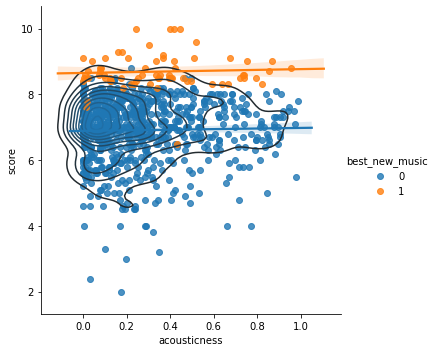

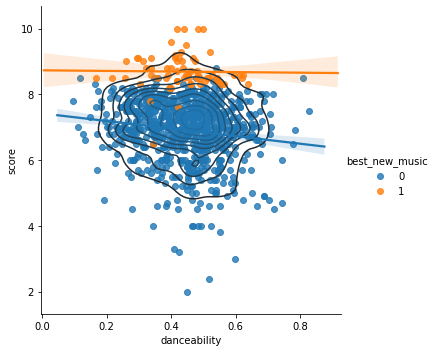

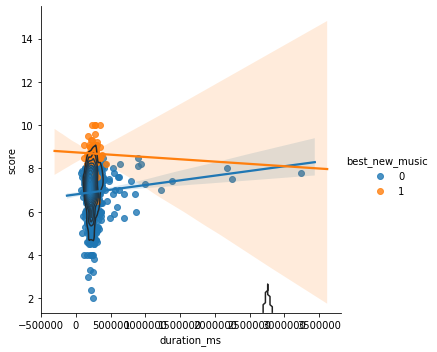

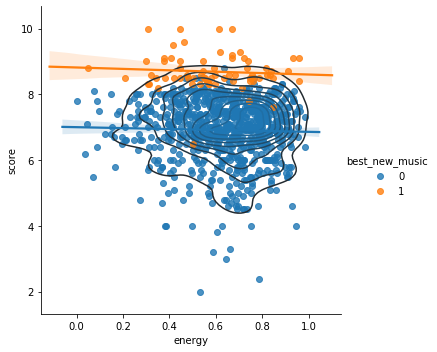

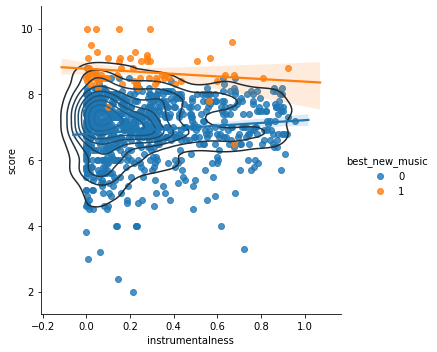

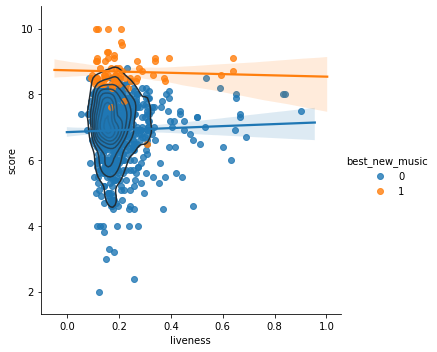

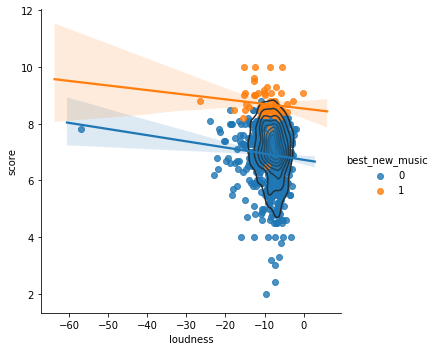

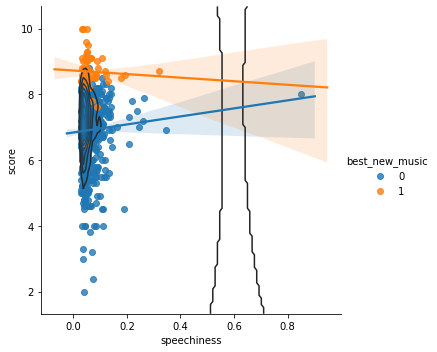

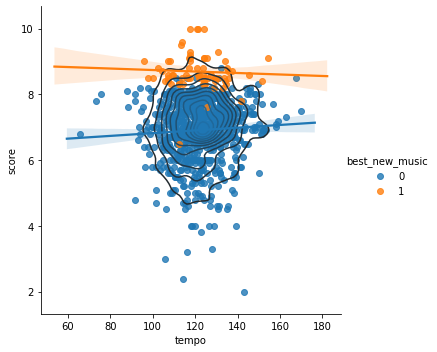

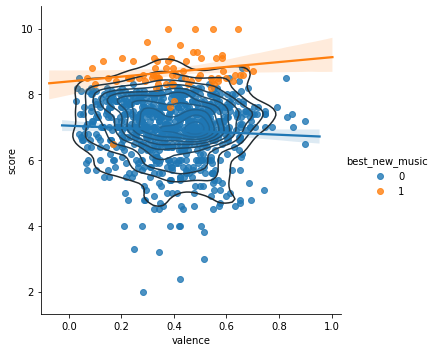

In [57]:
metrics = ["acousticness", "danceability", "duration_ms","energy","instrumentalness","liveness","loudness","speechiness","tempo","valence"]

for metric in metrics:
    sns.lmplot(x=metric, y="score", data=averages,
           fit_reg=True, # No regression line
           hue='best_new_music'
            )
    sns.kdeplot(averages[metric], averages.score)

As expected, it is difficult to draw correlations between these metrics and Pitchfork scores; the subject is simply too subjective to definitively ascribe a conclusion to. However, there is an interesting subset of the data that could be of interest. Pitchfork will ocasionally give exceptional works the label of "Best New Music". Usually, these albums score in the 8-10 range, and they are highlighted in the graphs above, however, there are some outliers that can be surprises, like the ~6.5 scoring BNM album in the graphs above (the lowest orange dot), as well as some odd high scorers that don't end up being granted the title of BNM.

Otherwise, scores tended to cluster strongly around the 6-7 range. This is a common criticism of many review outlets, as it is seen as a weakness that the reviewer is not willing to take a definitive stand for or against the given work. This realignment of a score that is considered "average" can skew the data and make it harder to observe nuance or any real differences between features and scores.

If there is a significant difference between the distribution of any given metric between Best New Music albums and non-BNM albums, then we can use that information to try to machine learn and predict whether an album will be BNM, given it's score! Let's try to compare the distributions of features between BNM and non-BNM

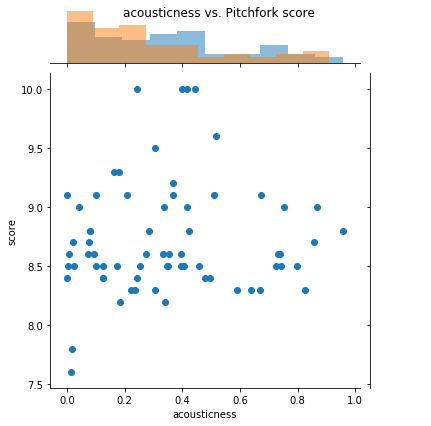

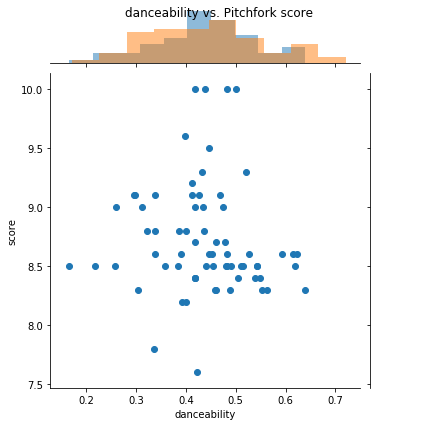

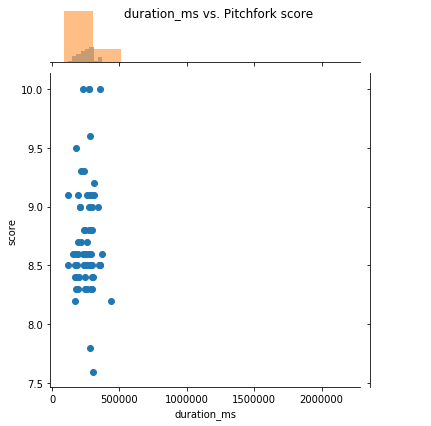

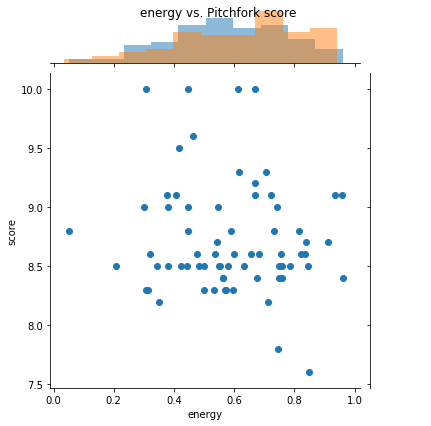

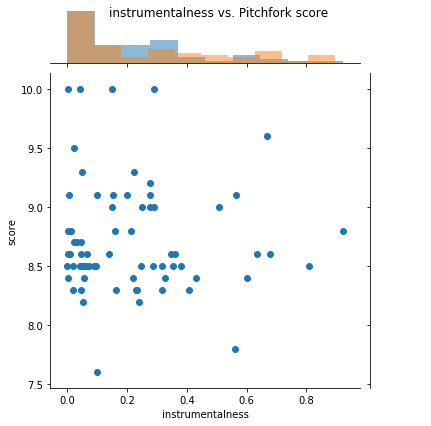

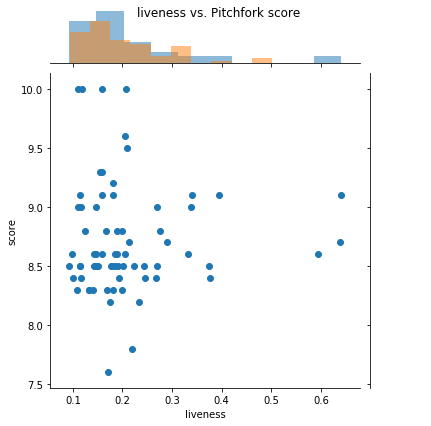

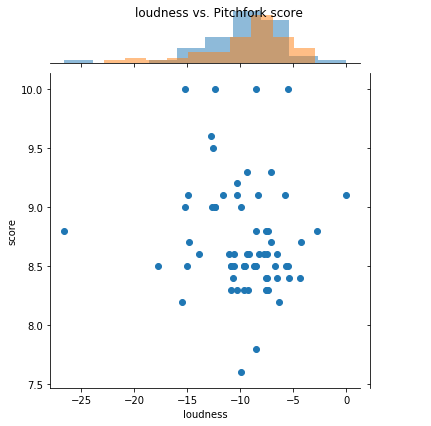

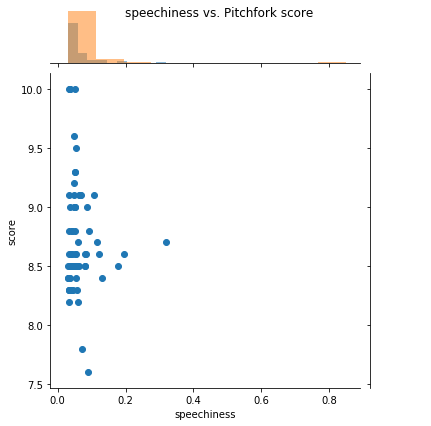

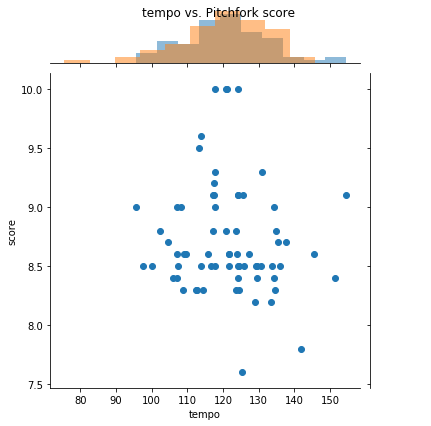

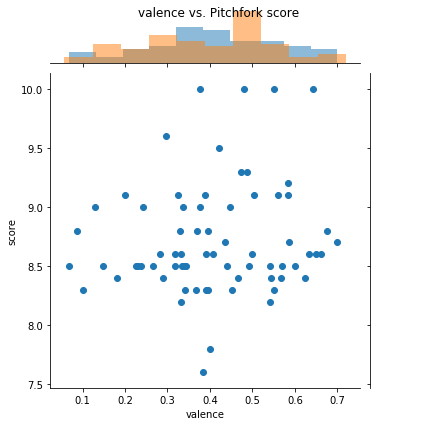

In [58]:
averages_bnm = averages[averages.best_new_music == 1]
averages_bnm = averages_bnm[averages_bnm.score > 7]

averages_non_bnm = averages[averages.best_new_music == 0]

bnm_rows, bnm_cols = averages_bnm.shape
non_bnm_sample = averages_non_bnm.sample(n = bnm_rows)

for metric in metrics:
    p = sns.JointGrid(
        x = averages_bnm[metric],
        y = averages_bnm.score
    )
    p.fig.suptitle(metric + " vs. Pitchfork score")
    p = p.plot_joint(
        plt.scatter
    )
    p.ax_marg_x.hist(
        averages_bnm[metric],
        alpha = 0.5
    )
    p.ax_marg_x.hist(
        non_bnm_sample[metric],
        alpha = 0.5
    )

The graphs above are scatter plots of the different metrics vs. Pitchfork score for Best New Music albums. Above the plot is a histogram of the distribution of BNM data (in blue) overlayed on a histogram of the distribution of non-bnm data (in orange). In order to match the weight of the amount of BNM albums, a random sample of the non-bnm data was chosen with the same amount of elements. 

Although the data changed from sample to sample on each run of the code, some metrics popped out as being significant. Some metrics, specifically liveness, acousticness, and instrumentalness tracked very closely to the distribution of non-BNM reviews. However, other metrics like dancability, loudness, and energy displayed significant distinct modal centers between the BNM and non-BNM categories. Likewise, the metric of speechiness had similar modal centers for BNM and non-BNM, but the BNM distribution was far larger.

This leads naturally to the first few generalizations we can make about the data: 

Pitchfork tends to favor albums that are/have
1. less danceable
2. less energetic
3. quieter
4. fewer spoken words

This lines up well with common knowledge regarding the blog -- it tends to favor and promote indie artists whose music is not neccesarily commercially successful or popular. Pop music today takes on qualities that are almost the opposite of those descriptors.

## Machine Learning <a id='ml'></a>

Although finding correlations might be difficult, and although the data doesn't neccesarily lend itself significantly to any dependence relationship, let's see if we can come up with *some* model to predict a set of songs' Pitchfork score anyways! 

First, lets try to predict whether an album will be Best New Music. Since an album can only either be or not be BNM, we can use logistic regression to create a binary model for it's likelihood. We'll use the out of the box statsmodels logistic regression model.

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
                                    averages.drop(['best_new_music'],axis=1),
                                    averages["best_new_music"],
                                    test_size = 0.30,
                                    )
                                                    
                                                    
log_model = sm.Logit(y_train, X_train)
result = log_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.087936
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:         best_new_music   No. Observations:                  593
Model:                          Logit   Df Residuals:                      578
Method:                           MLE   Df Model:                           14
Date:                Sun, 15 Dec 2019   Pseudo R-squ.:                  0.7079
Time:                        15:32:30   Log-Likelihood:                -52.146
converged:                       True   LL-Null:                       -178.55
Covariance Type:            nonrobust   LLR p-value:                 7.564e-46
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
acousticness         0.9557      1.903      0.502      0.615      -2.773       4.685
danceabili

In [60]:
print(result.conf_int())

                          0          1
acousticness      -2.773449   4.684914
danceability      -6.428030   6.954084
duration_ms       -0.000009   0.000004
energy            -7.649229   8.246400
instrumentalness  -3.643667   1.778964
key               -0.648253   0.272439
liveness          -6.011232   4.779193
loudness          -0.236894   0.359171
mode              -4.793659   1.376776
speechiness      -17.256753  11.254102
tempo             -0.042085   0.049210
time_signature    -3.277771   2.652856
valence           -6.039290   3.848670
score              4.757724   8.540955
pub_year          -0.034926  -0.015530


Oof! Some of those P values are very large. That said, the summary and confidence intervals for this model tell us that there is a strong confidence in the inverse relationship between danceability and speechiness with the album being Best New Music, and as expected, a positive relation between score and BNM. This aligns with our earlier generalizations. 

Now let's test the model out to see what the accuracy is.

In [61]:
predictions = log_model.predict(result.params, X_test)
predictions = [0.0 if x < 0.5 else 1.0 for x in predictions]

print(classification_report(y_test, predictions, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.992     0.996       238
           1      0.895     1.000     0.944        17

    accuracy                          0.992       255
   macro avg      0.947     0.996     0.970       255
weighted avg      0.993     0.992     0.992       255



Wow! ~80% precision for determining if an album is Best New Music! That's great, but expected nonetheless, considering that anything above a 8.0 is usually granted a BNM. 

Let's see what the predictions would look like if we exclude the score from the data, to see if we can generate a prediction for BNM purely with the music features, since including the score could be an example of bleeding crucial data:

In [62]:
# this time in the train/test split, we drop the score as well
X_train, X_test, y_train, y_test = train_test_split(
                                    averages.drop(['best_new_music', 'score'],axis=1),
                                    averages["best_new_music"],
                                    test_size = 0.30,
                                    )
                                                    
                                                    
log_model = sm.Logit(y_train, X_train)
result = log_model.fit()

predictions = log_model.predict(result.params, X_test)
#rounding the prediction to the nearest whole number
predictions = [0.0 if x < 0.5 else 1.0 for x in predictions]

print(classification_report(y_test, predictions, digits=3))

Optimization terminated successfully.
         Current function value: 0.273134
         Iterations 7
              precision    recall  f1-score   support

           0      0.925     0.992     0.957       236
           1      0.000     0.000     0.000        19

    accuracy                          0.918       255
   macro avg      0.462     0.496     0.479       255
weighted avg      0.856     0.918     0.886       255



Oof! 0% precision for determining BNM! That's miserable, but expected nonetheless. Much of this poor result probably comes down to sample size: there were only ~50 BNMs to train on, and that was a randomly sampled subset of the total data to begin with. The data being generally distributed evenly among metrics exacerbates this problem.

Now, let's try to see if we can predict an album's score! Much of the process will be the same, and I predict similarly lackluster results. 

In [63]:
X_train, X_test, y_train, y_test = train_test_split(
                                    averages.drop(['best_new_music', "score"],axis=1),
                                    averages["score"],
                                    test_size = 0.30,
                                    )

rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [64]:
score_predictions = rf.predict(X_test)
#rounding the predicted score to the nearest 10th
score_predictions = [round(x, 1) for x in score_predictions]

print(rf.score(X_test, y_test))
print(score_predictions)

0.0009954189902026123
[6.8, 7.0, 6.9, 7.4, 7.2, 6.7, 6.2, 7.3, 7.3, 7.0, 7.1, 6.7, 7.0, 7.5, 7.1, 6.6, 7.0, 6.8, 6.6, 6.4, 7.0, 6.7, 6.9, 7.1, 7.0, 6.7, 6.9, 7.1, 6.6, 7.2, 7.3, 6.9, 7.5, 6.9, 7.1, 7.1, 7.2, 7.2, 7.2, 6.9, 6.8, 7.0, 6.9, 6.6, 7.2, 6.9, 7.2, 7.3, 6.8, 7.2, 6.9, 6.7, 7.2, 6.4, 6.8, 7.2, 7.0, 6.9, 7.3, 6.8, 7.6, 6.9, 7.2, 7.4, 7.1, 7.3, 6.6, 7.2, 7.3, 7.3, 6.8, 6.9, 7.1, 6.7, 7.5, 7.0, 7.1, 7.2, 6.7, 7.2, 7.2, 7.3, 7.2, 7.0, 7.2, 7.1, 7.2, 6.7, 7.3, 7.8, 6.9, 7.0, 7.5, 7.3, 5.9, 6.9, 6.3, 6.8, 6.7, 7.1, 7.1, 7.3, 7.3, 7.3, 6.2, 7.3, 7.2, 7.1, 7.2, 7.2, 7.4, 6.4, 7.1, 6.5, 7.1, 7.5, 6.7, 6.6, 7.1, 6.8, 7.0, 6.8, 7.3, 6.4, 7.5, 7.2, 6.9, 7.1, 7.4, 6.4, 7.5, 7.1, 7.0, 6.8, 6.6, 6.9, 7.4, 6.7, 6.3, 6.8, 6.8, 7.0, 7.4, 6.9, 7.3, 7.3, 7.1, 7.2, 6.8, 6.5, 7.2, 8.4, 6.8, 6.5, 6.7, 6.9, 7.1, 7.5, 6.8, 7.3, 6.8, 7.3, 7.1, 7.3, 6.5, 6.5, 6.6, 6.7, 7.4, 6.7, 7.4, 7.1, 6.6, 6.8, 7.2, 7.2, 7.4, 6.7, 6.9, 6.9, 7.0, 7.2, 7.1, 6.9, 7.2, 7.2, 6.9, 6.7, 7.3, 6.8, 7.6, 6.8, 7.0, 7.2, 7.2, 6.

Wow! The prediction score was... *exceptionally* bad! That said, that result is completely expected. As I have said before, the data is just too subjective and doesn't present any clear correlations to seriously judge and predict quantitatively. That said, I predict that the accuracy of this model would probably go up if there were a larger set of albums to pull from, as well as if the model was built assuming a smaller range of scores, since scores in general clustered around the 6-7 mark. This would give the model some extra nuance to decide on a score.


## Conclusion <a id='conclusion'></a>
(*)
<img src="https://cdn4.pitchfork.com/longform/790/85_Atmosphere_Pooneh_Ghana_07-20QM6A8440.jpg" width = 50% height = 50%/>


Throughout this project we learned much about how difficult it is to wrangle data, especially when it is in different forms across different media. The data collection portion was largely an exercise in entity resolution, as matching reviewids with Spotify ids, exptrapolating those into track ids, and etrapolating track ids into track features required a careful understanding of how to chain API calls while representing and joining data cleanly and effectively.  

Likewise, the EDA section was an exercise in coming up with the right questions to ask so that we could draw out some enlightening conclusions from otherwise obvious data, however weakly supported those conclusions may be. 

Although the machine learning was largely inconclusive, the existence of the models we created comes with a bit of novelty: using this framework, we can now assign a Pitchfork score to any given playlist or album, regardless of whether it has one or not, and have it tell you if it's best new music! Intergrating the Spotify API to grab playlists, format their data for the ML model, and spitting out a score could be a possible area for further exploration.

(*) image from the Pitchfork Music Festival 2018